In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [37]:
# Global Parameters
V = 2.4
I = 2*0.0211
m_s = 0.168

R = 8.3145
T = 302.15
n4 = 4
F = 9.649e4
nS = 1
nS2 = 2
nS4 = 4
nS8 = 8
Ms = 32
nu = 0.0114
iH0 = 1
iL0 = 0.5
ar = 0.960
alpha = n4*F/(2*R*T)
beta = alpha/2
EL0 = 2.0
EH0 = 2.35
fL = (nS**2)*nS2*(Ms**2)*(nu**2)/nS4
fH = (nS4**2)*Ms*nu/nS8

# initial discharge functions
def S4_initial_discharge(S,S2):
    
    return S2*(S**2)*np.exp((V-EL0)/beta)/fL

def S8_initial_discharge(S4):
    sinh_term = np.arcsinh(-I/(2*iH0*ar))/alpha
    return (S4**2)*np.exp((V-EH0-sinh_term)/beta)/fH
    

In [38]:
m_s

0.168

In [50]:
feasible_S_ic = []
feasible_S2_ic = []
feasible_S4_ic = []
feasible_S8_ic = []

S_space = np.linspace(1e-10,m_s,100)
for S in S_space:
    S2_space = np.linspace(1e-10,m_s-S,100)
    for S2 in S2_space:
        S4 = S4_initial_discharge(S,S2)
        S8 = S8_initial_discharge(S4)
        if S8 > 0 and S4 > 0 and S+S2+S4+S8<m_s:
            feasible_S_ic.append(S)
            feasible_S2_ic.append(S2)
            feasible_S4_ic.append(S4)
            feasible_S8_ic.append(S8)
            

In [52]:
max(feasible_S8_ic)

0.00011108878919815888

In [53]:
max(feasible_S4_ic)

0.008996906933891994

Text(0, 0.5, 'S2 [g]')

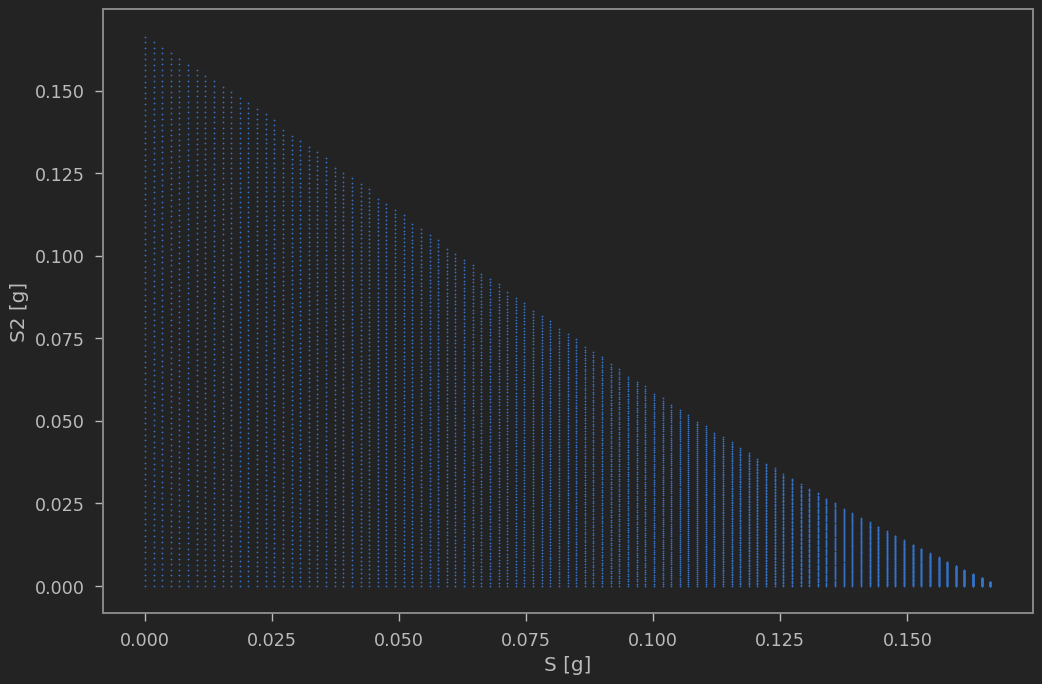

In [48]:
plt.scatter(feasible_S_ic,feasible_S2_ic,s=1)
plt.xlabel('S [g]')
plt.ylabel('S2 [g]')

In [21]:
V = 1.5
# initial discharge functions
def S4_final_discharge(S,S2):
    sinh_term = np.arcsinh(-I/(2*iL0*ar))/alpha
    return S2*(S**2)*np.exp((V-EL0-sinh_term)/beta)/fL

def S8_final_discharge(S4):
    
    return (S4**2)*np.exp((V-EH0)/beta)/fH

In [22]:
feasible_S_final = []
feasible_S2_final = []
feasible_Sp_final = []
S_space = np.linspace(1e-10,m_s,100)
for S in S_space:
    S2_space = np.linspace(1e-10,m_s-S,100)
    for S2 in S2_space:
        S4 = S4_final_discharge(S,S2)
        S8 = S8_final_discharge(S4)
        Sp = m_s - S - S2 - S4 - S8
        if S4 > 0 and S8 > 0 and S+S2+S4+S8<m_s:
            feasible_S_final.append(S)
            feasible_S2_final.append(S2)
            feasible_Sp_final.append(Sp)
            

Text(0, 0.5, 'S2 [g]')

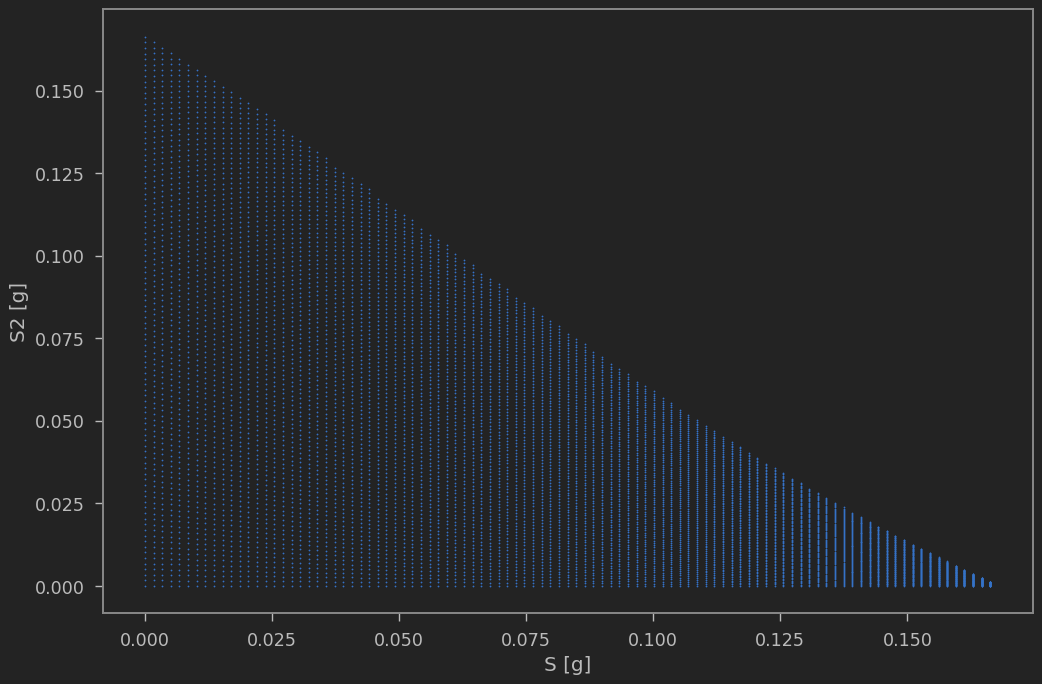

In [23]:
plt.scatter(feasible_S_final,feasible_S2_final,s=1)
plt.xlabel('S [g]')
plt.ylabel('S2 [g]')

In [30]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s



# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2
temp =302.15
# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

#S8_initial_hunt = S8_initial_frac*m_s_hunt
#S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
#Sp_initial_hunt = Sp_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_discharge(S1_initial_hunt,S2_initial_hunt)
S8_initial_hunt = S8_initial_discharge(S4_initial_hunt)
Sp_initial_hunt = m_s_hunt - S1_initial_hunt - S2_initial_hunt - S4_initial_hunt - S8_initial_hunt

V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        'S saturation mass [g]': 0.09
    }                      
]
fitted_params_dict = all_params[-1]
current = 2*0.0211 # .2C discharge
model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()

# non-fitted parameters
params = model.default_parameter_values
params.update(
    {
    "Current function [A]": current, # 2C charge
    "Ambient Temperature [K]": temp
    }
)
# fitted parameters (which are initial species values and initial voltage)
params.update(fitted_params_dict)

# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
    ),
)


In [31]:
discharge_initial_data

[2.4,
 2.3530424505786557e-39,
 4.1894913584542535e-20,
 2.7097715846291745e-07,
 1.020894763111026e-07,
 0.16799962693336523]

In [25]:
hours = 10/2
time_in_seconds = hours*3600
output = sim.solve(np.linspace(0, time_in_seconds,10**3))


'''
print("Starting temperature %f" %(temp))
for j in [3,4,5,6]:
    print("trying number of time steps %f" %10**j)
    print("parameters are {}".format(fitted_params_dict))
    try:
        # simulate
        sim.solve(np.linspace(0, time_in_seconds,10**j))
        # extract data
        t = sim.solution.t
        Ah = abs(current)*t/3600
        V = sim.solution["Terminal voltage [V]"].entries
        S8 = sim.solution["S8 [g]"].entries
        S4 = sim.solution["S4 [g]"].entries
        S2 = sim.solution["S2 [g]"].entries
        S1 = sim.solution["S [g]"].entries
        Sp = sim.solution["Precipitated Sulfur [g]"].entries
        Tc = sim.solution["Cell Temperature [K]"].entries
        data = {'time' : t,'capacity' : Ah,'voltage' : V,'S8' : S8,'S4' : S4,'S2' : S2,'S1' : S1,'Sp' : Sp, 'temp' : Tc} 
'''

SolverError: Could not find consistent states: 
                        Could not find acceptable solution: solver terminated
                        successfully, but maximum solution error (2.98219e-05)
                        above tolerance (1e-06)
                        

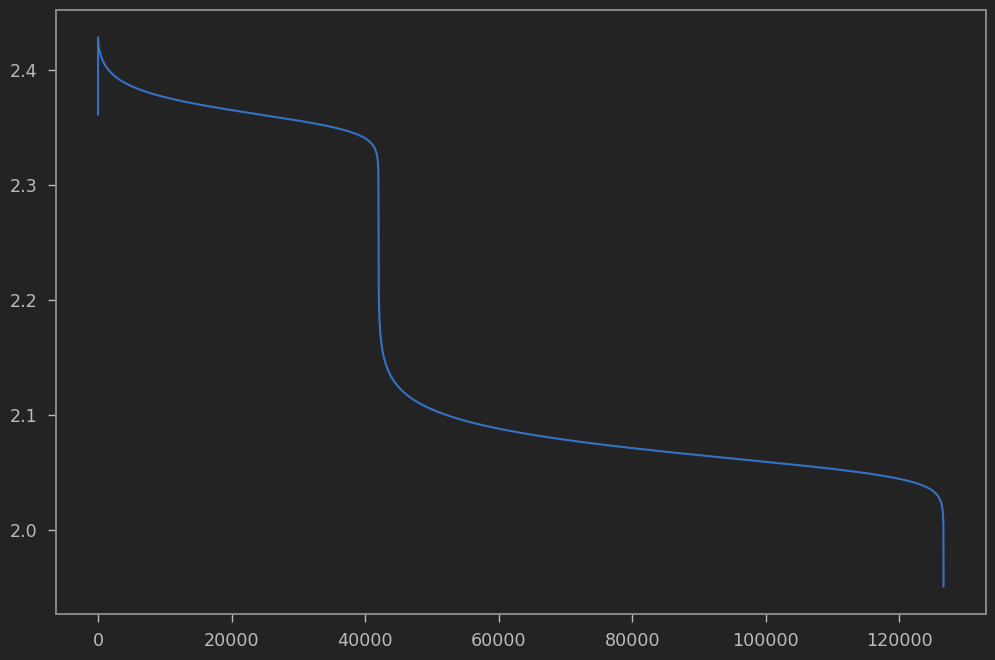

In [15]:
plt.plot(sim.solution['Terminal voltage [V]'].entries)
notify

In [10]:
def discharge_function(inputs):
    
    fitted_params_dict, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Ambient Temperature [K]": temp
        }
    )
    # fitted parameters (which are initial species values and initial voltage)
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries

            data = {'time' : t, 
                    'capacity' : Ah, 
                    'voltage' : V, 
                    'S8' : S8, 
                    'S4' : S4, 
                    'S2' : S2, 
                    'S1' : S1, 
                    'Sp' : Sp, 
                   } 
            return data
            
            break
        except:
            pass

In [11]:
all_data = []
for temp in [292.15,302.15,312.15]:
    inputs = fitted_params_dict, temp
    data = discharge_function(inputs)
    all_data.append(data)
    


Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07}
trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07}
trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
The linesearch algorithm failed with too small a step.
Newton/Linesearch algorithm failed to converge.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07}
trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07}
trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
Newton/Linesearch algorithm failed to converge.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../

TypeError: 'NoneType' object is not subscriptable

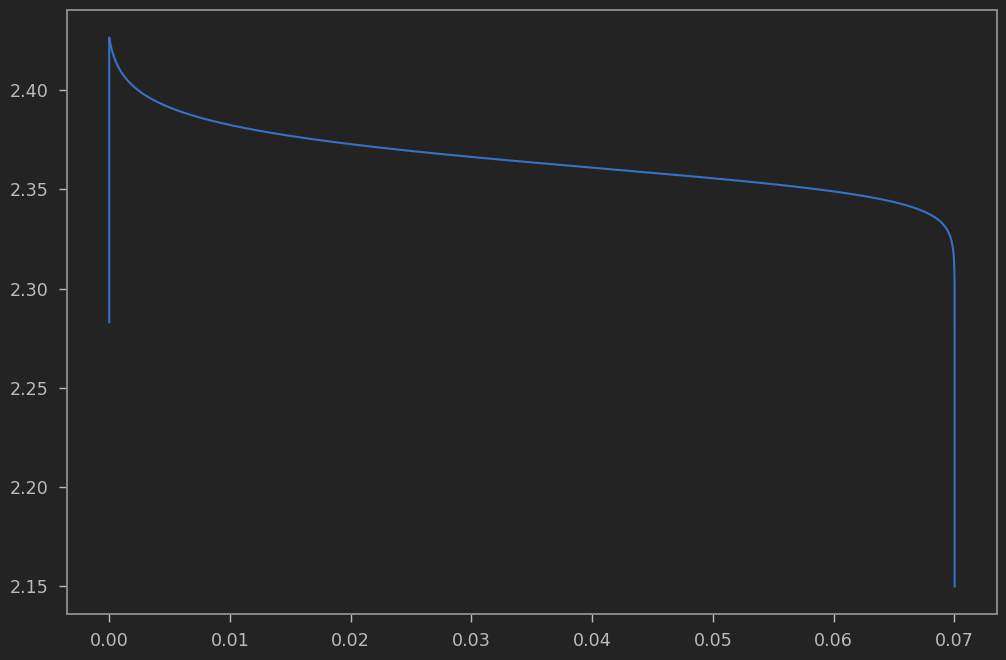

In [12]:
for data in all_data:
    plt.plot(data['capacity'],data['voltage'])
plt.legend(['20','30','40'])    
